In [1]:
import os
import sys

import numpy as np
import pandas as pd
import polars as pl

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

# Random Seeds
SEED=3093453
np.random.seed(SEED)
tf.random.set_seed(SEED)



# Cosmetics
np.set_printoptions(
    edgeitems=30,
    linewidth=100_000,
    suppress=True
    )

sns.set(
    context="talk",
    style="darkgrid"
)


cwd = os.getcwd()
cwd, _ = os.path.split(cwd)

In [2]:


df = pd.DataFrame(columns = ["Set", "Filename", "raw"])


#for Set in ["A", "B", "C"]:
for Set in ["X"]:
    path = os.path.join(cwd, "data", Set)
    for dirpath, dirnames, filenames in os.walk(path):
        filenames = sorted(filenames)
        for filename in filenames:
            if not filename.endswith(".out"):
                continue
            filepath = os.path.join(dirpath, filename)
            #print(filename)
            with open(filepath, "r") as f:
                raw_text = f.read()
            
            data = pd.DataFrame([[Set, filename[:-4], raw_text]], columns = ["Set", "Filename", "raw"])
            df = pd.concat([df, data])


#df = df[df.Filename.str.contains(r"[A-Z][A-Z]\d?\-\d{1,3}")]

df["Threshold"] = df["Filename"].str.extract("\-(\d*)").astype(float)
df["Instance"] = df["Filename"].str.split("-").str[0]
df = df.sort_values(["Set", "Filename"]).reset_index(drop=True)
df

,Set,Filename,raw,Threshold,Instance
0,X,AS,"cpu-bind=MASK - cn-0002, task 0 0 [2204321]:...",NaN,AS
1,X,AS2,"cpu-bind=MASK - cn-0256, task 0 0 [978147]: ...",NaN,AS2
2,X,AS3,"cpu-bind=MASK - cn-0214, task 0 0 [2414625]:...",NaN,AS3
3,X,AS4,"cpu-bind=MASK - cn-0245, task 0 0 [3948989]:...",NaN,AS4
4,X,AS4-0,"cpu-bind=MASK - cn-0138, task 0 0 [884319]: ...",0.0,AS4
...,...,...,...,...,...
460,X,VA5-90,"cpu-bind=MASK - cn-0118, task 0 0 [1325281]:...",90.0,VA5
461,X,VA6,"cpu-bind=MASK - cn-0129, task 0 0 [110430]: ...",NaN,VA6
462,X,VA6-90,"cpu-bind=MASK - cn-0194, task 0 0 [1929485]:...",90.0,VA6
463,X,VA7,"cpu-bind=MASK - cn-0013, task 0 0 [3206379]:...",NaN,VA7


In [3]:
df["finalObjective"] = df.raw.str.extract("Final Solution\nObjective;(\d*\.?\d?)\nTransportation cost;").astype(float)
df["finalTransportationCost"] = df.raw.str.extract("Final Solution\nObjective;\d*\.?\d?\nTransportation cost;(\d*\.?\d?)").astype(float)
df["finalInventoryCost"] = df.raw.str.extract(
    "Final Solution\nObjective;\d*\.?\d?\nTransportation cost;\d*\.?\d?\nInventory cost;(\d*\.?\d?)"
).astype(float)
df["Runtime"] = df.raw.str.extract(
    "Final Solution\nObjective;\d*\.?\d?\nTransportation cost;\d*\.?\d?\nInventory cost;\d*\.?\d?\nRuntime;(\d*\.?\d?)"
).astype(float)
#df["finalObjective"].hist()

In [4]:
num_LNS_iterations = df["raw"].str.extractall(r"LNS iteration (\d*)").astype(int).reset_index().groupby("level_0")[0].max()

In [5]:
num_LNS_iterations = df["raw"].str.extractall(r"LNS iteration (\d*)").astype(int).reset_index().groupby("level_0")[0].max()
#num_LNS_iterations.index.name=
num_LNS_iterations.name = "num_LNS_iter"
df = df.join(num_LNS_iterations)
df["num_LNS_iter"] = df["num_LNS_iter"].fillna(0).astype(int)

In [6]:
df

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter
0,X,AS,"cpu-bind=MASK - cn-0002, task 0 0 [2204321]:...",NaN,AS,2017343.0,1942200.0,75143.0,3590.9,3
1,X,AS2,"cpu-bind=MASK - cn-0256, task 0 0 [978147]: ...",NaN,AS2,2173535.0,2043600.0,129935.0,3595.7,3
2,X,AS3,"cpu-bind=MASK - cn-0214, task 0 0 [2414625]:...",NaN,AS3,9809539.0,9706500.0,103039.0,3597.4,3
3,X,AS4,"cpu-bind=MASK - cn-0245, task 0 0 [3948989]:...",NaN,AS4,2048455.0,1975500.0,72955.0,3596.1,3
4,X,AS4-0,"cpu-bind=MASK - cn-0138, task 0 0 [884319]: ...",0.0,AS4,2350418.0,2277000.0,73418.0,3591.1,1
...,...,...,...,...,...,...,...,...,...,...
460,X,VA5-90,"cpu-bind=MASK - cn-0118, task 0 0 [1325281]:...",90.0,VA5,36755.0,32100.0,4655.0,4.9,0
461,X,VA6,"cpu-bind=MASK - cn-0129, task 0 0 [110430]: ...",NaN,VA6,119026.0,106500.0,12526.0,7.9,0
462,X,VA6-90,"cpu-bind=MASK - cn-0194, task 0 0 [1929485]:...",90.0,VA6,119026.0,106500.0,12526.0,9.4,0
463,X,VA7,"cpu-bind=MASK - cn-0013, task 0 0 [3206379]:...",NaN,VA7,29109.0,24000.0,5109.0,6.4,0


In [7]:
reference_df = df[df.Threshold.isnull()].copy()
df = df[~df.Threshold.isnull()].copy().reset_index(drop=True)
df["Threshold"] = df["Threshold"].astype(int)
df

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter
0,X,AS4-0,"cpu-bind=MASK - cn-0138, task 0 0 [884319]: ...",0,AS4,2350418.0,2277000.0,73418.0,3591.1,1
1,X,AS4-10,"cpu-bind=MASK - cn-0143, task 0 0 [2294103]:...",10,AS4,2389063.0,2313900.0,75163.0,3592.8,1
2,X,AS4-100,"cpu-bind=MASK - cn-0094, task 0 0 [2077564]:...",100,AS4,1967014.0,1892400.0,74614.0,2683.2,23
3,X,AS4-20,"cpu-bind=MASK - cn-0150, task 0 0 [2957653]:...",20,AS4,2356451.0,2282400.0,74051.0,3594.9,1
4,X,AS4-30,"cpu-bind=MASK - cn-0194, task 0 0 [1882243]:...",30,AS4,2372303.0,2300400.0,71903.0,3593.9,1
...,...,...,...,...,...,...,...,...,...,...
355,X,VA5-70,"cpu-bind=MASK - cn-0102, task 0 0 [1546102]:...",70,VA5,36755.0,32100.0,4655.0,4.5,0
356,X,VA5-80,"cpu-bind=MASK - cn-0102, task 0 0 [1546096]:...",80,VA5,36755.0,32100.0,4655.0,4.5,0
357,X,VA5-90,"cpu-bind=MASK - cn-0118, task 0 0 [1325281]:...",90,VA5,36755.0,32100.0,4655.0,4.9,0
358,X,VA6-90,"cpu-bind=MASK - cn-0194, task 0 0 [1929485]:...",90,VA6,119026.0,106500.0,12526.0,9.4,0


In [8]:
reference_df

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter
0,X,AS,"cpu-bind=MASK - cn-0002, task 0 0 [2204321]:...",NaN,AS,2017343.0,1942200.0,75143.0,3590.9,3
1,X,AS2,"cpu-bind=MASK - cn-0256, task 0 0 [978147]: ...",NaN,AS2,2173535.0,2043600.0,129935.0,3595.7,3
2,X,AS3,"cpu-bind=MASK - cn-0214, task 0 0 [2414625]:...",NaN,AS3,9809539.0,9706500.0,103039.0,3597.4,3
3,X,AS4,"cpu-bind=MASK - cn-0245, task 0 0 [3948989]:...",NaN,AS4,2048455.0,1975500.0,72955.0,3596.1,3
15,X,AS5,"cpu-bind=MASK - cn-0202, task 0 0 [588995]: ...",NaN,AS5,2217620.0,2084700.0,132920.0,3594.9,3
...,...,...,...,...,...,...,...,...,...,...
436,X,VA3,"cpu-bind=MASK - cn-0014, task 0 0 [1643472]:...",NaN,VA3,120032.0,105000.0,15032.0,29.6,0
437,X,VA4,"cpu-bind=MASK - cn-0049, task 0 0 [1727902]:...",NaN,VA4,29709.0,24600.0,5109.0,6.4,0
449,X,VA5,"cpu-bind=MASK - cn-0056, task 0 0 [3451343]:...",NaN,VA5,36755.0,32100.0,4655.0,4.7,0
461,X,VA6,"cpu-bind=MASK - cn-0129, task 0 0 [110430]: ...",NaN,VA6,119026.0,106500.0,12526.0,7.9,0


In [9]:
df = df.merge(
    reference_df[["Set", "Instance", "finalTransportationCost", "finalInventoryCost", "finalObjective", "Runtime", "num_LNS_iter"]],
    how="left",
    on=["Set", "Instance"],
    suffixes=("", "_Reference"),
    
)
df

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter,finalTransportationCost_Reference,finalInventoryCost_Reference,finalObjective_Reference,Runtime_Reference,num_LNS_iter_Reference
0,X,AS4-0,"cpu-bind=MASK - cn-0138, task 0 0 [884319]: ...",0,AS4,2350418.0,2277000.0,73418.0,3591.1,1,1975500.0,72955.0,2048455.0,3596.1,3
1,X,AS4-10,"cpu-bind=MASK - cn-0143, task 0 0 [2294103]:...",10,AS4,2389063.0,2313900.0,75163.0,3592.8,1,1975500.0,72955.0,2048455.0,3596.1,3
2,X,AS4-100,"cpu-bind=MASK - cn-0094, task 0 0 [2077564]:...",100,AS4,1967014.0,1892400.0,74614.0,2683.2,23,1975500.0,72955.0,2048455.0,3596.1,3
3,X,AS4-20,"cpu-bind=MASK - cn-0150, task 0 0 [2957653]:...",20,AS4,2356451.0,2282400.0,74051.0,3594.9,1,1975500.0,72955.0,2048455.0,3596.1,3
4,X,AS4-30,"cpu-bind=MASK - cn-0194, task 0 0 [1882243]:...",30,AS4,2372303.0,2300400.0,71903.0,3593.9,1,1975500.0,72955.0,2048455.0,3596.1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,X,VA5-70,"cpu-bind=MASK - cn-0102, task 0 0 [1546102]:...",70,VA5,36755.0,32100.0,4655.0,4.5,0,32100.0,4655.0,36755.0,4.7,0
356,X,VA5-80,"cpu-bind=MASK - cn-0102, task 0 0 [1546096]:...",80,VA5,36755.0,32100.0,4655.0,4.5,0,32100.0,4655.0,36755.0,4.7,0
357,X,VA5-90,"cpu-bind=MASK - cn-0118, task 0 0 [1325281]:...",90,VA5,36755.0,32100.0,4655.0,4.9,0,32100.0,4655.0,36755.0,4.7,0
358,X,VA6-90,"cpu-bind=MASK - cn-0194, task 0 0 [1929485]:...",90,VA6,119026.0,106500.0,12526.0,9.4,0,106500.0,12526.0,119026.0,7.9,0


In [10]:
df["Subset"] = "Training"
df.loc[(df.Set == "X") & (df.Instance.str.endswith("4") | df.Instance.str.endswith("5")), "Subset"] = "Validation"
df.loc[(df.Set == "X") & (df.Instance.str.endswith("6") | df.Instance.str.endswith("7")), "Subset"] = "Testing"

In [11]:
df = df[(df["Subset"] == "Validation")]

In [12]:
clms = df.columns

for clm in clms[clms.str.contains("_Reference")]:
    clm_clean = clm.split("_Reference")[0]
    df[clm_clean] = df[clm_clean] / df[clm]

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_29232/2554790196.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[clm_clean] = df[clm_clean] / df[clm]


In [13]:
df

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter,finalTransportationCost_Reference,finalInventoryCost_Reference,finalObjective_Reference,Runtime_Reference,num_LNS_iter_Reference,Subset
0,X,AS4-0,"cpu-bind=MASK - cn-0138, task 0 0 [884319]: ...",0,AS4,1.147410,1.152620,1.006346,0.998610,0.333333,1975500.0,72955.0,2048455.0,3596.1,3,Validation
1,X,AS4-10,"cpu-bind=MASK - cn-0143, task 0 0 [2294103]:...",10,AS4,1.166276,1.171298,1.030265,0.999082,0.333333,1975500.0,72955.0,2048455.0,3596.1,3,Validation
2,X,AS4-100,"cpu-bind=MASK - cn-0094, task 0 0 [2077564]:...",100,AS4,0.960243,0.957935,1.022740,0.746142,7.666667,1975500.0,72955.0,2048455.0,3596.1,3,Validation
3,X,AS4-20,"cpu-bind=MASK - cn-0150, task 0 0 [2957653]:...",20,AS4,1.150355,1.155353,1.015023,0.999666,0.333333,1975500.0,72955.0,2048455.0,3596.1,3,Validation
4,X,AS4-30,"cpu-bind=MASK - cn-0194, task 0 0 [1882243]:...",30,AS4,1.158094,1.164465,0.985580,0.999388,0.333333,1975500.0,72955.0,2048455.0,3596.1,3,Validation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,X,VA5-50,"cpu-bind=MASK - cn-0072, task 0 0 [755674]: ...",50,VA5,1.000000,1.000000,1.000000,1.000000,NaN,32100.0,4655.0,36755.0,4.7,0,Validation
354,X,VA5-60,"cpu-bind=MASK - cn-0077, task 0 0 [583708]: ...",60,VA5,1.000000,1.000000,1.000000,0.957447,NaN,32100.0,4655.0,36755.0,4.7,0,Validation
355,X,VA5-70,"cpu-bind=MASK - cn-0102, task 0 0 [1546102]:...",70,VA5,1.000000,1.000000,1.000000,0.957447,NaN,32100.0,4655.0,36755.0,4.7,0,Validation
356,X,VA5-80,"cpu-bind=MASK - cn-0102, task 0 0 [1546096]:...",80,VA5,1.000000,1.000000,1.000000,0.957447,NaN,32100.0,4655.0,36755.0,4.7,0,Validation


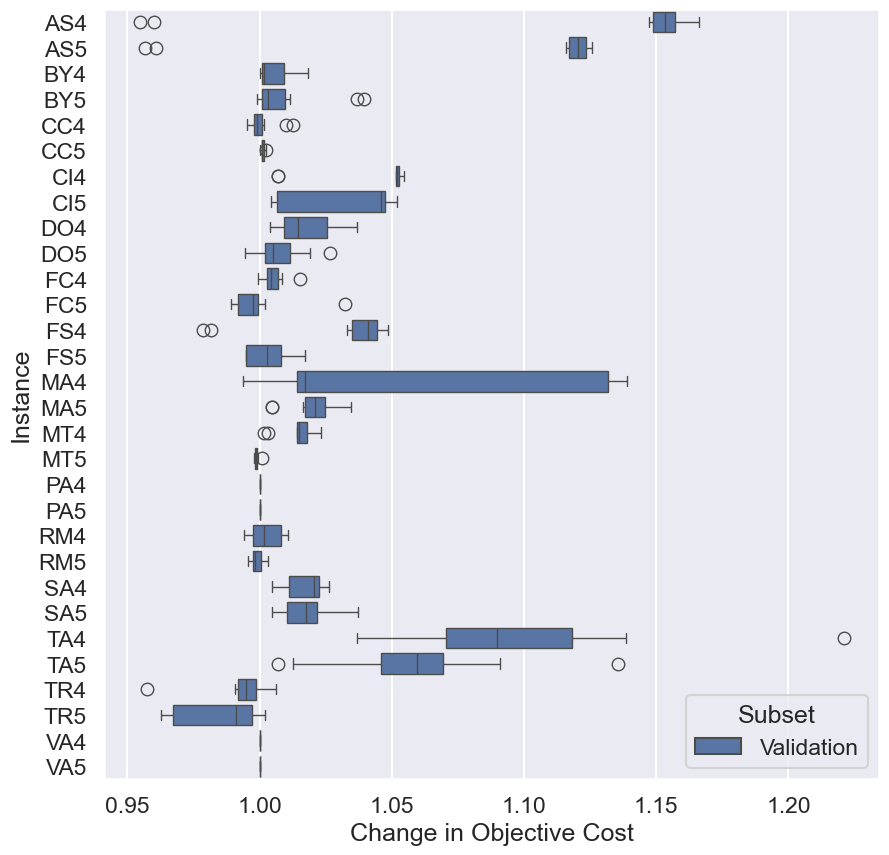

In [14]:
plt.figure(figsize=(10, 10))
#sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Set");
sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Subset");
plt.xlabel("Change in Objective Cost");

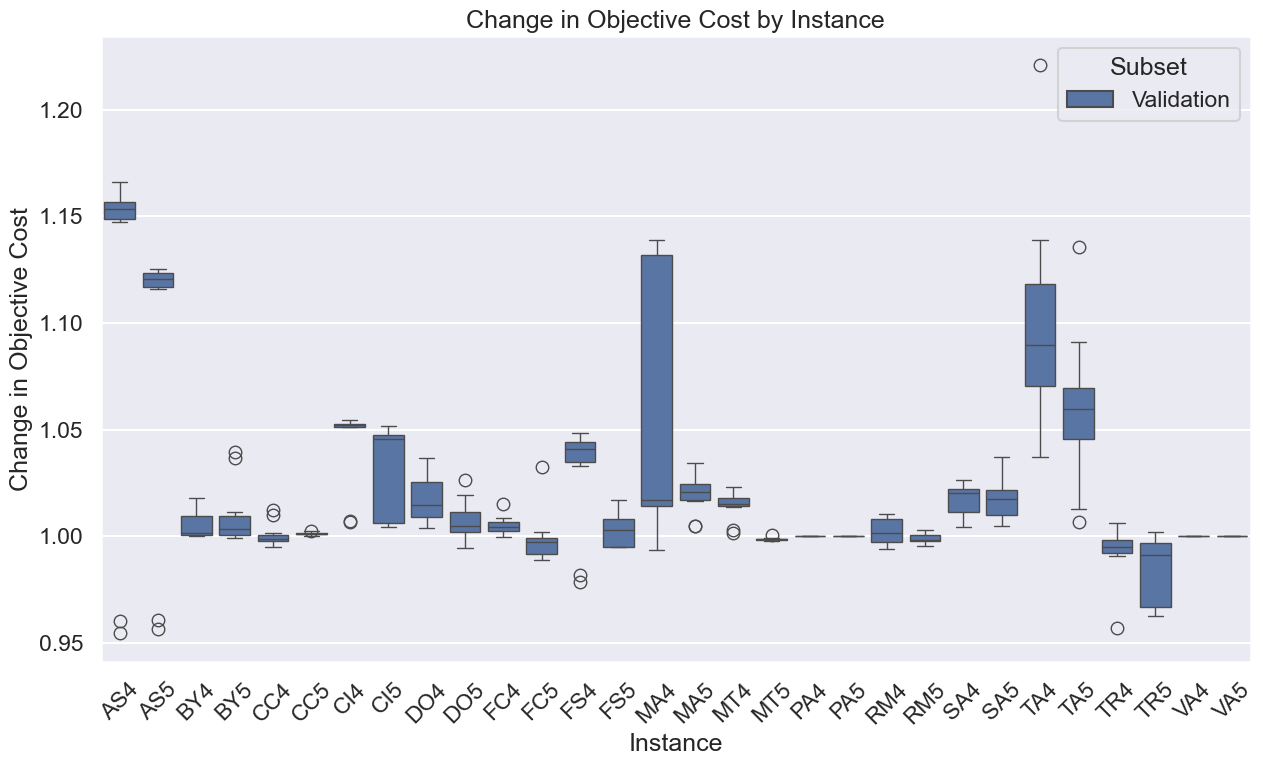

In [15]:
plt.figure(figsize=(13, 8))
#sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Set");
sns.boxplot(data=df, x="Instance", y="finalObjective", hue="Subset");
plt.ylabel("Change in Objective Cost");
plt.title("Change in Objective Cost by Instance");
plt.xticks(rotation=45);

plt.tight_layout()
for file_format in ["png", "jpg", "pdf", "svg"]:
    path = os.path.join(cwd, "plots", "2024-02-14-ExperimentsThreshold", f"Change in Objective by Instance.{file_format}")
    plt.savefig(path)


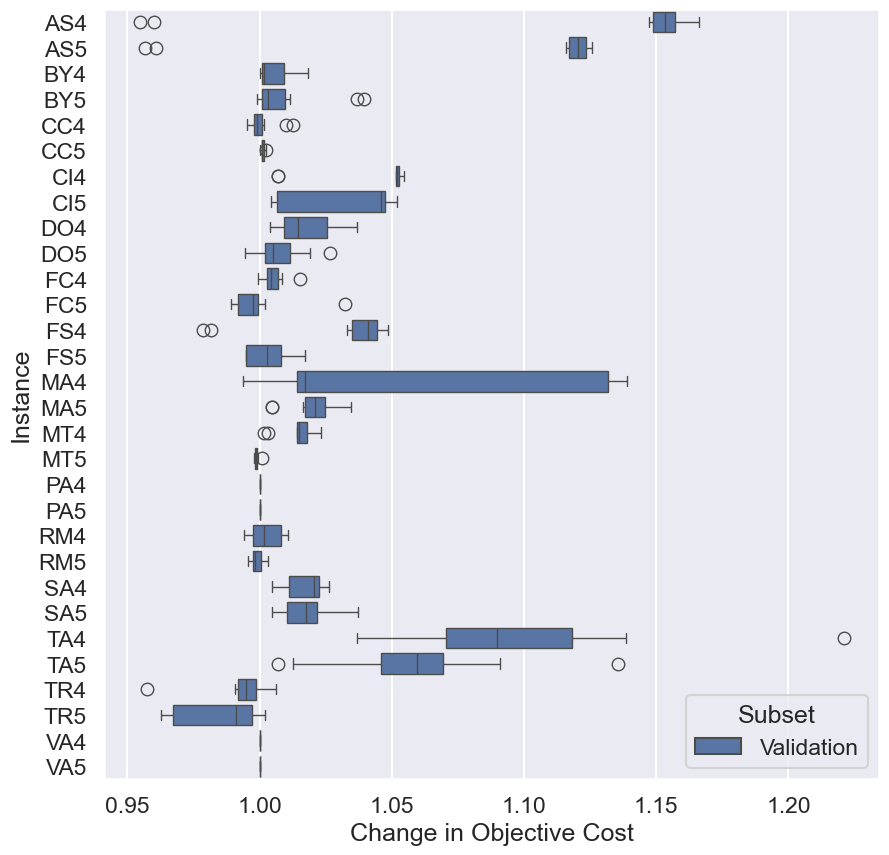

In [16]:
plt.figure(figsize=(10, 10))
#sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Set");
sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Subset");
plt.xlabel("Change in Objective Cost");

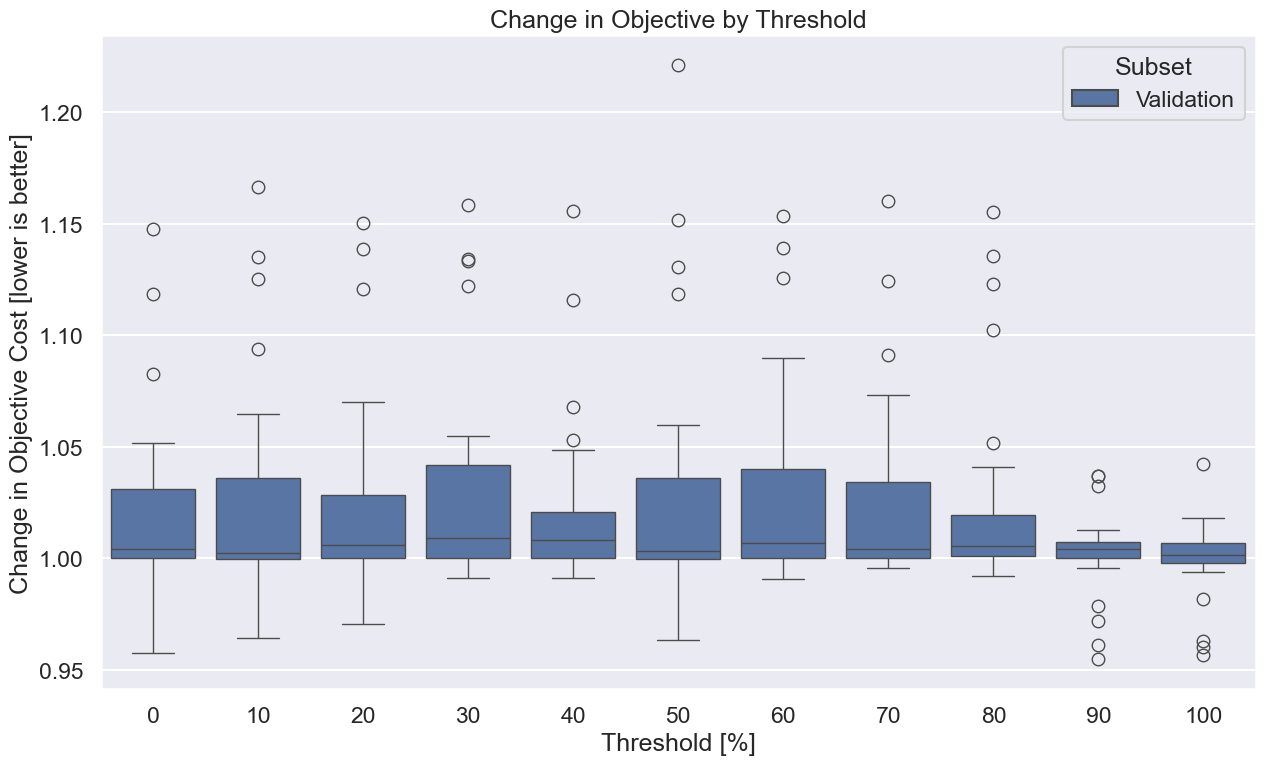

In [17]:
plt.figure(figsize=(13, 8))
sns.boxplot(data=df, y="finalObjective", x="Threshold", hue="Subset");
plt.xlabel("Threshold [%]")
plt.ylabel("Change in Objective Cost [lower is better]");
plt.title("Change in Objective by Threshold")

plt.tight_layout()
for file_format in ["png", "jpg", "pdf", "svg"]:
    path = os.path.join(cwd, "plots", "2024-02-14-ExperimentsThreshold", f"Change in Objective by Threshold.{file_format}")
    plt.savefig(path)


In [18]:
x = df.finalObjective[df.Threshold == 90]
x = x[~x.isnull()]

t_value = (1-x.mean()) / x.std() * len(x)**0.5
t_value

-0.7353701659270626

In [19]:
from scipy.stats import t

t.pdf(t_value, df=len(x)-1)

0.29978496380327224

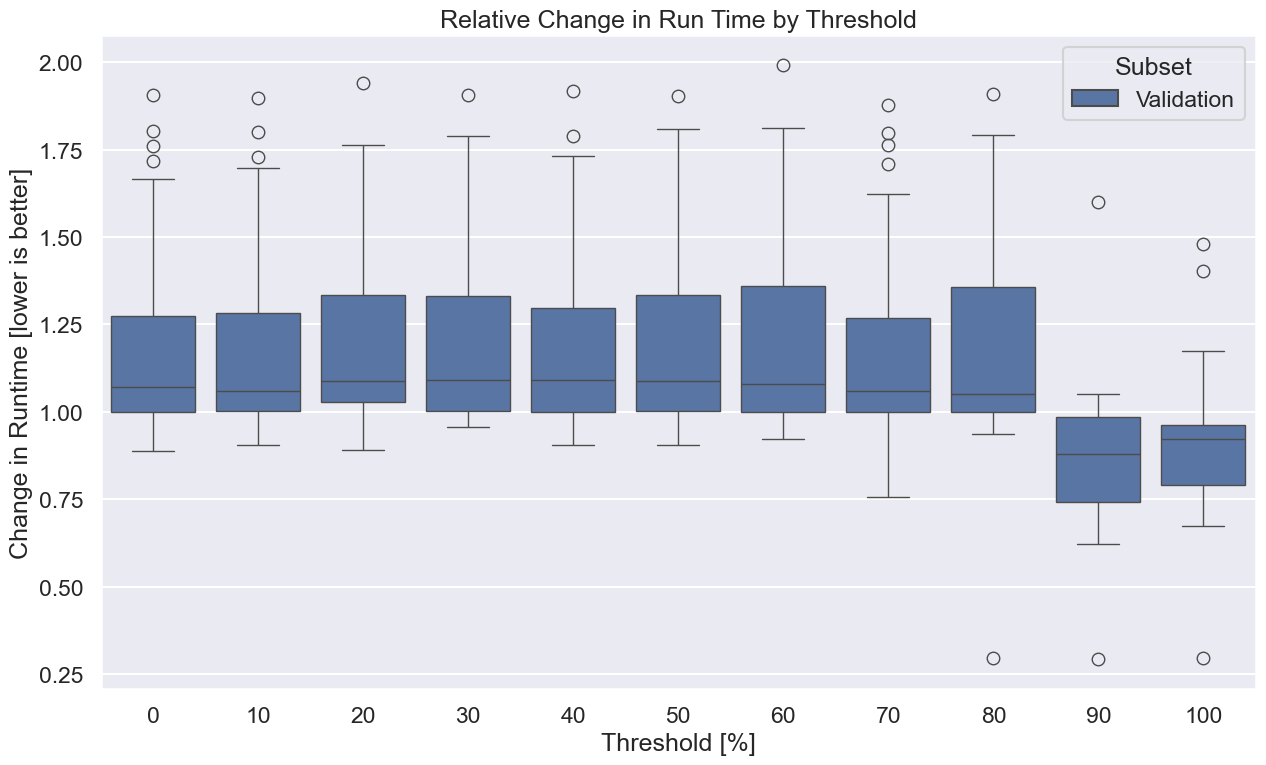

In [25]:
plt.figure(figsize=(13, 8))
sns.boxplot(data=df, y="Runtime", x="Threshold", hue="Subset");
plt.xlabel("Threshold [%]")
plt.ylabel("Change in Runtime [lower is better]");
plt.title("Relative Change in Run Time by Threshold")


plt.tight_layout()
for file_format in ["png", "jpg", "pdf", "svg"]:
    path = os.path.join(cwd, "plots", "2024-02-14-ExperimentsThreshold", f"Change in Runtime by Threshold VALIDATION.{file_format}")
    plt.savefig(path)

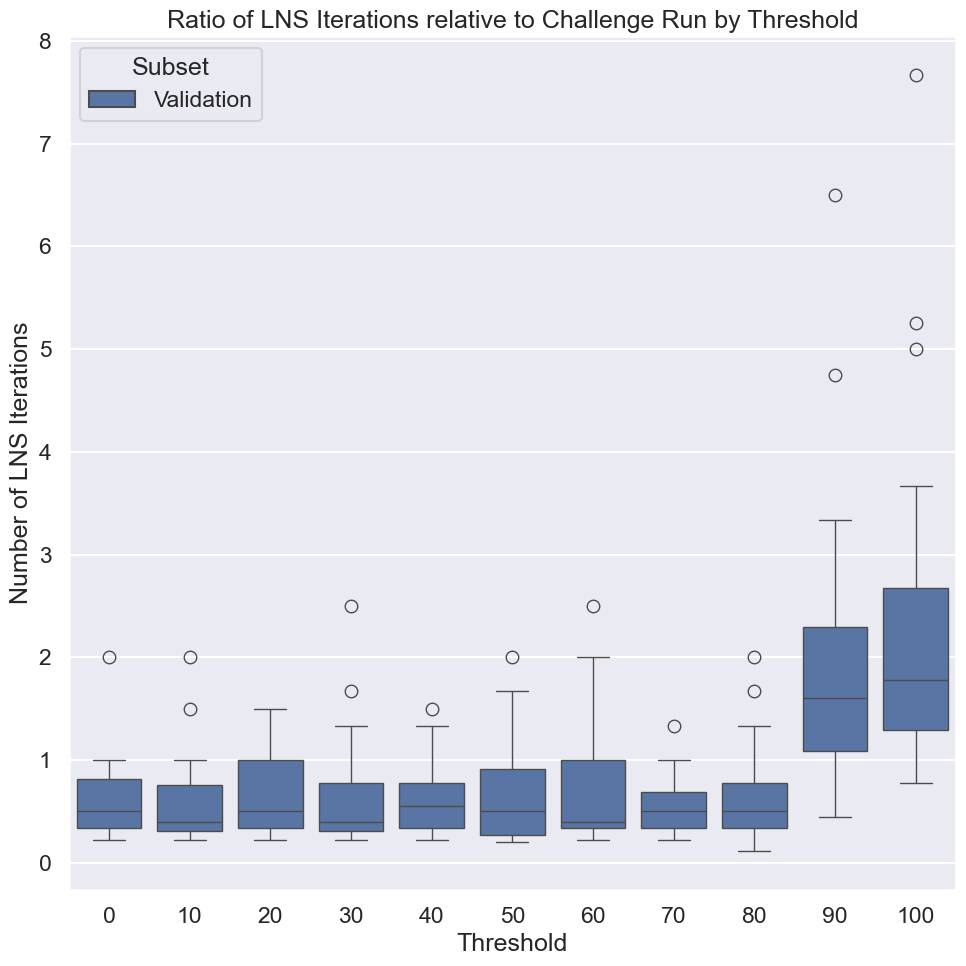

In [21]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df, y="num_LNS_iter", x="Threshold", hue="Subset");
plt.ylabel("Number of LNS Iterations");
plt.title("Ratio of LNS Iterations relative to Challenge Run by Threshold");
plt.tight_layout()

In [22]:
reference_df[(reference_df.Set == "A")&(reference_df.Instance == "BU")]

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter


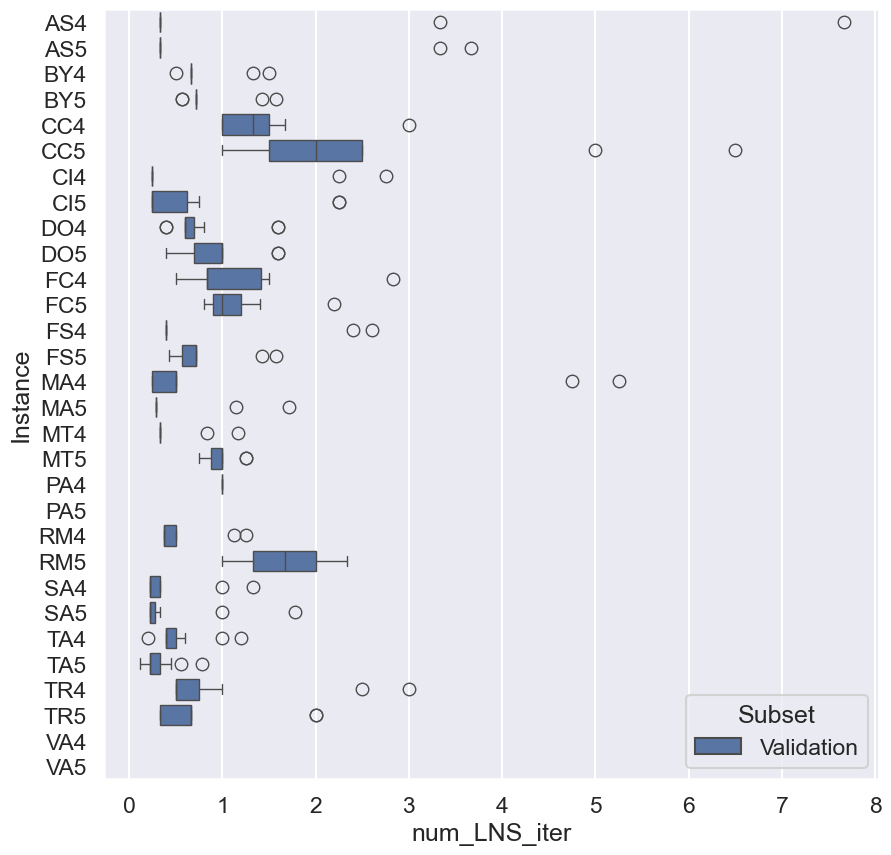

In [23]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df, y="Instance", x="num_LNS_iter", hue="Subset");
#plt.ylabel("Change in Runtime");